# Датасет

Датасет содержит изображения кошек с шерстью и без.

In [1]:
# https://drive.google.com/file/d/1Ec4mQ2lhaqlS6bi4iNboUNvKtCriahwP/view?usp=sharing

! gdown --id 1Ec4mQ2lhaqlS6bi4iNboUNvKtCriahwP

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Ec4mQ2lhaqlS6bi4iNboUNvKtCriahwP
To: /content/my_dataset.zip
100% 770k/770k [00:00<00:00, 126MB/s]


In [2]:
! unzip /content/my_dataset.zip

Archive:  /content/my_dataset.zip
   creating: dataset/test/
   creating: dataset/test/fluffy/
  inflating: dataset/test/fluffy/fluffy_35.jpg  
  inflating: dataset/test/fluffy/fluffy_36.jpg  
  inflating: dataset/test/fluffy/fluffy_37.jpg  
  inflating: dataset/test/fluffy/fluffy_38.jpg  
  inflating: dataset/test/fluffy/fluffy_39.jpg  
  inflating: dataset/test/fluffy/fluffy_40.jpg  
  inflating: dataset/test/fluffy/fluffy_41.jpg  
  inflating: dataset/test/fluffy/fluffy_42.jpg  
  inflating: dataset/test/fluffy/fluffy_43.jpg  
  inflating: dataset/test/fluffy/fluffy_44.jpg  
   creating: dataset/test/hairless/
  inflating: dataset/test/hairless/hairless_35.jpg  
  inflating: dataset/test/hairless/hairless_36.jpg  
  inflating: dataset/test/hairless/hairless_37.jpg  
  inflating: dataset/test/hairless/hairless_38.jpg  
  inflating: dataset/test/hairless/hairless_39.jpg  
  inflating: dataset/test/hairless/hairless_40.jpg  
  inflating: dataset/test/hairless/hairless_41.jpg  
  inflat

Посмотрим на изображения из датасета.

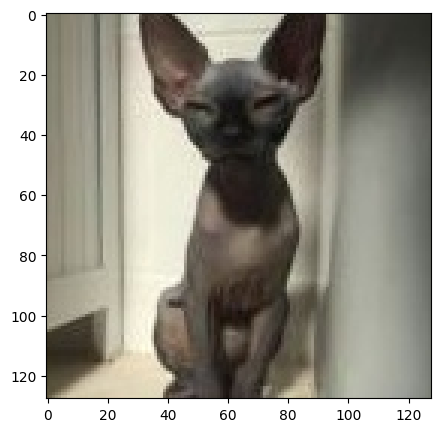

In [3]:
from PIL import Image
import matplotlib.pyplot as plt

image = Image.open('dataset/train/hairless/hairless_0.jpg')

plt.figure(figsize=(5, 5))
plt.imshow(image)
plt.show()

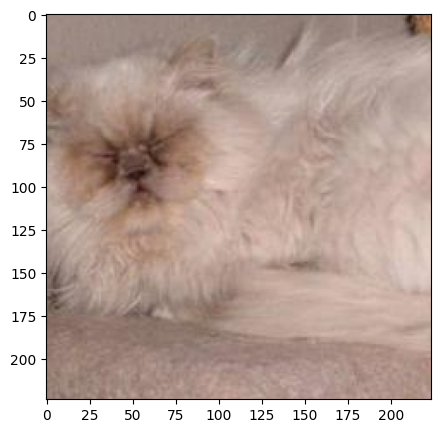

In [4]:
image = Image.open('dataset/train/fluffy/fluffy_0.jpg')

plt.figure(figsize=(5, 5))
plt.imshow(image)
plt.show()

Обучим модель определять с шерстью кошка или нет.

In [5]:
import torch
import torchvision.models as models

# Загружаем предобученный ResNet-18
model = models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 84.6MB/s]


In [6]:
# Заморозим все предобученные веса
for param in model.parameters():
    param.requires_grad = False

In [7]:
# Добавим еще слой для новых классов
num_classes = 2
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

In [32]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
import albumentations as A

# Определим трансформации для входных изображений
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_full_aug = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

transform_rc = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

transform_cj = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

transform_ra = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

# Загружаем данные для обучения
default_train_dataset = ImageFolder('dataset/train', transform=transform)
full_aug_train_dataset = ImageFolder('dataset/train', transform=transform_full_aug) + default_train_dataset
rc_train_dataset = ImageFolder('dataset/train', transform=transform_rc) + default_train_dataset
cj_train_dataset = ImageFolder('dataset/train', transform=transform_cj) + default_train_dataset
ra_train_dataset = ImageFolder('dataset/train', transform=transform_ra) + default_train_dataset

test_dataset = ImageFolder('dataset/test', transform=transform)
val_dataset = ImageFolder('dataset/val', transform=transform)

In [33]:
# Определим фукнцию потерь и оптимизатор
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

In [34]:
from torch.utils.data import DataLoader

# Создадим DataLoader'ы для данных
default_train_loader = DataLoader(default_train_dataset, batch_size=32, shuffle=True)
full_aug_train_loader = DataLoader(full_aug_train_dataset, batch_size=32, shuffle=True)
rc_train_loader = DataLoader(rc_train_dataset, batch_size=32, shuffle=True)
cj_train_loader = DataLoader(cj_train_dataset, batch_size=32, shuffle=True)
ra_train_loader = DataLoader(ra_train_dataset, batch_size=32, shuffle=True)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [35]:
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    # Обучение модели указанное количество эпох
    for epoch in range(num_epochs):
        # Переводим модель в режим обучения
        model.train()

        # Инициализируем значение ошибки
        running_loss = 0.0
        running_corrects = 0

        # Итерируемся по батчам из dataloader'а
        for inputs, labels in train_loader:
            # Переносим изображения и метки на устройство, на котором будет обучаться модель
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Зануляем градиент
            optimizer.zero_grad()

            # Прогоняем изображение через сеть
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Вычисляем ошибку и корректируем веса
            loss.backward()
            optimizer.step()

            # Обновляем значение ошибки на батче
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        # Считаем среднее значение ошибки во время обучения
        train_loss = running_loss / len(default_train_dataset)
        train_acc = running_corrects.double() / len(default_train_dataset)

        # Переводим модель в режим проверки
        model.eval()

        running_loss = 0.0
        running_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:

                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

        val_loss = running_loss / len(val_dataset)
        val_acc = running_corrects.double() / len(val_dataset)

        # Выводим результат обучения на эпохе
        print('Epoch [{}/{}], train loss: {:.4f}, train acc: {:.4f}, val loss: {:.4f}, val acc: {:.4f}'
              .format(epoch+1, num_epochs, train_loss, train_acc, val_loss, val_acc))

In [36]:
def test(model, test_loader, device):
    # Устанавливаем модель в режим оценки
    model.eval()

    correct_preds = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            total_samples += labels.size(0)
            # correct_preds += (preds == labels).sum().item()
            correct_preds += torch.sum(preds == labels.data)

    accuracy = correct_preds / total_samples
    print(f'Test Accuracy: {accuracy * 100:.2f}%')

In [37]:
# Выбираем устройство
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_data_list = [default_train_loader, full_aug_train_loader, rc_train_loader, cj_train_loader, ra_train_loader]
for i, train_data in enumerate(train_data_list):
    model_ = model
    model_.to(device)

    print(f"TRAIN {i}")
    train(model_, train_data, val_loader, criterion, optimizer, num_epochs=10, device=device)
    test(model_, test_loader, device=device)
    print("\n_____________________________")

TRAIN 0
Epoch [1/10], train loss: 0.0347, train acc: 1.0000, val loss: 0.1885, val acc: 0.9000
Epoch [2/10], train loss: 0.0342, train acc: 1.0000, val loss: 0.1898, val acc: 0.9000
Epoch [3/10], train loss: 0.0398, train acc: 1.0000, val loss: 0.1885, val acc: 0.9000
Epoch [4/10], train loss: 0.0366, train acc: 1.0000, val loss: 0.2227, val acc: 0.9000
Epoch [5/10], train loss: 0.0396, train acc: 1.0000, val loss: 0.2080, val acc: 0.9000
Epoch [6/10], train loss: 0.0351, train acc: 1.0000, val loss: 0.2255, val acc: 0.9000
Epoch [7/10], train loss: 0.0390, train acc: 1.0000, val loss: 0.2038, val acc: 0.9000
Epoch [8/10], train loss: 0.0484, train acc: 1.0000, val loss: 0.2024, val acc: 0.9000
Epoch [9/10], train loss: 0.0538, train acc: 0.9857, val loss: 0.2389, val acc: 0.9000
Epoch [10/10], train loss: 0.0368, train acc: 1.0000, val loss: 0.2317, val acc: 0.9000
Test Accuracy: 90.00%

_____________________________
TRAIN 1
Epoch [1/10], train loss: 0.2761, train acc: 1.9000, val los

In [39]:
import pandas as pd

# Построим сводную таблицу с результатами
results = pd.DataFrame(
    data=[
        (0.0368, 90),
        (0.1966, 90),
        (0.0805, 90),
        (0.0778, 90),
        (0.1423, 90),
    ],
    columns=["train_loss", "test_accuracy"],
    index=pd.Index(["default", "full_aug", "random_crop", "color_jitter", "random_affine"])
)
results

,train_loss,test_accuracy
default,0.0368,90
full_aug,0.1966,90
random_crop,0.0805,90
color_jitter,0.0778,90
random_affine,0.1423,90


In [40]:
# Обучим последний слой на данных, которые показали лучший результат
model.to(device)
train(model, default_train_loader, val_loader, criterion, optimizer, num_epochs=10, device=device)

# Проверяем модель на тестовых данных
test(model, test_loader, device=device)

Epoch [1/10], train loss: 0.0783, train acc: 0.9571, val loss: 0.1838, val acc: 0.9000
Epoch [2/10], train loss: 0.0265, train acc: 1.0000, val loss: 0.1499, val acc: 1.0000
Epoch [3/10], train loss: 0.0720, train acc: 0.9857, val loss: 0.1429, val acc: 1.0000
Epoch [4/10], train loss: 0.1043, train acc: 0.9714, val loss: 0.1310, val acc: 1.0000
Epoch [5/10], train loss: 0.0942, train acc: 0.9714, val loss: 0.1450, val acc: 0.9000
Epoch [6/10], train loss: 0.0417, train acc: 0.9857, val loss: 0.2583, val acc: 0.9000
Epoch [7/10], train loss: 0.0465, train acc: 0.9857, val loss: 0.5366, val acc: 0.7000
Epoch [8/10], train loss: 0.1014, train acc: 0.9714, val loss: 0.6312, val acc: 0.7000
Epoch [9/10], train loss: 0.0829, train acc: 0.9571, val loss: 0.4021, val acc: 0.8000
Epoch [10/10], train loss: 0.0509, train acc: 0.9857, val loss: 0.3210, val acc: 0.9000
Test Accuracy: 90.00%


Посмотрим работу модели на конкретных примерах.

In [41]:
# Посмотрим, какой индекс какому классу принадлежит
default_train_dataset.class_to_idx

{'fluffy': 0, 'hairless': 1}

In [47]:
model.eval()

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [48]:
def show_predicted(image_path, model, classes_dict):
    image = Image.open(image_path)

    input_tensor = preprocess(image)
    input_batch = input_tensor.unsqueeze(0)

    with torch.no_grad():
        output = model(input_batch)

    predictions = torch.nn.functional.softmax(output[0], dim=0)
    class_idx = torch.argmax(predictions)
    class_name = [i[0] for i in classes_dict.items() if i[1] == class_idx.item()][0]

    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.title(class_name)
    plt.show()

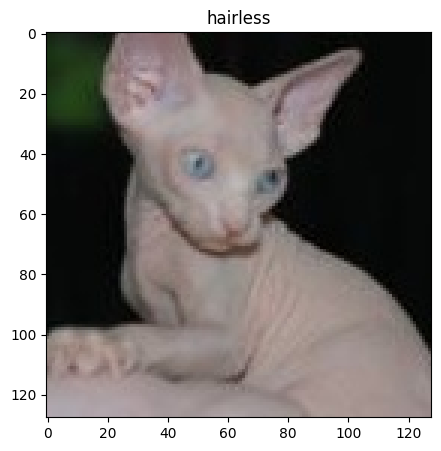

In [49]:
image_path = 'dataset/test/hairless/hairless_37.jpg'

show_predicted(image_path, model, default_train_dataset.class_to_idx)

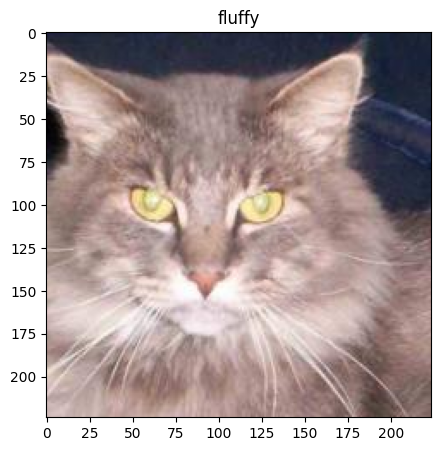

In [50]:
image_path = 'dataset/test/fluffy/fluffy_37.jpg'

show_predicted(image_path, model, default_train_dataset.class_to_idx)